# Unveiling Diabetic Trends: Exploring Lifestyle Patterns for Diagnosis Using Supervised Learning

#### The following cell's code (import statements etc.) is provided for you and you should not need to change it.

In [1]:
# import common utility functions
from common import *

/Users/hansika/Documents/MLE/env/mle/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Let's check our software versions
print('------------')
print('### Python version: ' + __import__('sys').version)
print('### NumPy version: ' + np.__version__)
print('### Scikit-learn version: ' + sklearn.__version__)
print('### Tensorflow version: ' + tf.__version__)
print('------------')

------------
### Python version: 3.9.6 (default, Nov 10 2023, 13:38:27) 
[Clang 15.0.0 (clang-1500.1.0.2.5)]
### NumPy version: 1.26.3
### Scikit-learn version: 1.4.0
### Tensorflow version: 2.15.0
------------


In [3]:
# set the seed
seed = 26

set_seed(seed)

epsf = 1e-9 # small epsilon value for floating point comparisons

Seed set to 26


### Loading data

In [4]:
diabetes_data = load_data('diabetes_012_health_indicators_BRFSS2015.csv')

Data loaded successfully data shape: (253680, 22)


In [9]:
diabetes_data.head()

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [6]:
diabetes_data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_012          253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

In [10]:
class_column = 'Diabetes_012'

unique_classes = diabetes_data[class_column].unique()

# Print the shape of the data for each class
for cls in unique_classes:
    class_data = diabetes_data[diabetes_data[class_column] == cls]
    print(f"Data for class {cls}: {class_data.shape}")

Data for class 0.0: (213703, 22)
Data for class 2.0: (35346, 22)
Data for class 1.0: (4631, 22)


In [17]:
train_x, train_y, test_x, test_y, val_x, val_y = split_and_scale_data(diabetes_data, oneHotEncode=True, verbose=True) 

Shape : train x: (228312, 21) y: (228312, 3), val x: (12684, 21) y: (12684, 21), test shape: (12684, 21) y: (12684, 3)


In [6]:
print(train_x[:5])

[[0.         0.         1.         0.23255814 0.         0.
  0.         0.         0.         0.         0.         1.
  0.         0.25       0.         0.         0.         1.
  0.5        0.8        1.        ]
 [1.         1.         1.         0.29069767 1.         0.
  0.         1.         1.         1.         0.         1.
  0.         0.5        0.33333333 0.         0.         1.
  0.58333333 0.8        0.85714286]
 [0.         0.         1.         0.22093023 1.         0.
  0.         0.         0.         1.         0.         1.
  0.         0.75       0.         1.         1.         1.
  0.5        0.6        0.57142857]
 [0.         0.         1.         0.1627907  0.         0.
  0.         1.         1.         1.         1.         1.
  0.         0.5        0.         0.         0.         0.
  0.75       0.8        1.        ]
 [0.         0.         1.         0.1744186  1.         0.
  0.         1.         0.         1.         0.         1.
  0.         0.5

In [14]:
# Let's create a custom callback class
class PerfEvalCustomCallback(keras.callbacks.Callback):
    
    def __init__(self, perf_data):
        self.perf_data = perf_data
    
    # we define the on_epoch_end callback and save the loss and accuracy in perf_data
    def on_epoch_end(self, epoch, logs=None):
        self.perf_data[epoch,0] = logs['loss']
        self.perf_data[epoch,1] = logs['accuracy']
        self.perf_data[epoch,2] = logs['val_loss']
        self.perf_data[epoch,3] = logs['val_accuracy']

    def get_perf_data():
        return self.perf_data

In [11]:
# Plot the model's performance during training (across epochs)
def plot_training_perf(train_loss, train_acc, val_loss, val_acc, ax=None, fs=(6,3)):
    no_ax_provided = ax == None
    if no_ax_provided:
        fig = plt.figure(figsize=fs)
        ax = plt.gca()

    assert train_loss.shape == val_loss.shape and train_loss.shape == val_acc.shape and val_acc.shape == train_acc.shape
    
    # assume we have one measurement per epoch
    num_epochs = train_loss.shape[0]
    epochs = np.arange(0, num_epochs)

    ax.plot(1+epochs, train_acc, 'r--', linewidth=2, label='Training')
    ax.plot(1+epochs, val_acc, 'b-', linewidth=2, label='Validation')
    
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Epoch')
    
    ax.set_xlim([1, num_epochs])

    ylim = [0.0, 1.01]
    ax.set_ylim(ylim)

    ax.legend()
    if no_ax_provided:
        plt.show()

In [10]:

def evaluate_model(name, model, eval_data, 
                   plot_training=True, evaluate_on_test_set=True, provide_classification_report=True, provide_confusion_matrix=True):
    
    # unpack the stuff
    perf_data, dataset = eval_data
    train_x, train_y, val_x, val_y, test_x, test_y = dataset
    
    
    train_preds = model.predict(train_x, verbose=0)
    val_preds = model.predict(val_x, verbose=0)
    

    train_accuracy_metric = keras.metrics.CategoricalAccuracy()
    val_accuracy_metric = keras.metrics.CategoricalAccuracy()

    train_accuracy_metric.update_state(train_y, train_preds)
    val_accuracy_metric.update_state(val_y, val_preds)

    train_acc = train_accuracy_metric.result().numpy()
    val_acc = val_accuracy_metric.result().numpy()


    print('[{}] Training Accuracy: {:.3f}%, Validation Accuracy: {:.3f}%'.format(name, 100*train_acc, 100*val_acc))
        
    if evaluate_on_test_set:
        test_loss, test_acc = model.evaluate(test_x, test_y, verbose=0)
        assert np.isnan(test_loss) or (test_loss == float(test_loss) and test_loss >= -1e8)
        assert np.isnan(test_acc) or (test_acc == float(test_acc) and test_acc >= 0 and test_acc < 1.0)
        print('[{}] Test loss: {:.5f}, test accuracy: {:.3f}%'.format(name, test_loss, 100*test_acc))

    if plot_training:
        plot_training_perf(perf_data[:,0], perf_data[:,1], perf_data[:,2], perf_data[:,3])
    
    if provide_classification_report:
        test_preds_indices = model.predict(test_x, verbose=0).argmax(axis=1)
        test_y_indices = np.argmax(test_y, axis=1)
        print("\n--- Classification Report (Test Set) ---")
        print(sklearn.metrics.classification_report(test_y_indices, test_preds_indices))

    if provide_confusion_matrix:
        confusion_mtx = sklearn.metrics.confusion_matrix(test_y_indices, test_preds_indices)
        plt.figure(figsize=(10, 8))
        sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=range(np.max(test_y_indices)+1), yticklabels=range(np.max(test_y_indices)+1))
        plt.title(f'Confusion Matrix for {name}')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()
        
    return


def train_model(model, max_epochs=10, batch_size=32, verbose=0, 
                   dataset=(train_x, train_y, val_x, val_y, test_x, test_y), class_weights=None):

    ## unpack dataset
    train_x, train_y, val_x, val_y, test_x, test_y = dataset
    
    early_stop_cb = keras.callbacks.EarlyStopping(monitor='loss', mode='min', patience=5)
    
    perf_data = np.zeros((max_epochs, 4))
    perf_eval_cb = PerfEvalCustomCallback(perf_data)

    hojb = None

    if class_weights is not None:
       hobj = model.fit(train_x, train_y, validation_data=(val_x, val_y), epochs=max_epochs, batch_size=batch_size, 
                  shuffle=True, callbacks=[perf_eval_cb, early_stop_cb], verbose=verbose, class_weight=class_weights)
    else:
        hobj = model.fit(train_x, train_y, validation_data=(val_x, val_y), epochs=max_epochs, batch_size=batch_size, 
                     shuffle=True, callbacks=[perf_eval_cb, early_stop_cb], verbose=verbose)
    
    eff_epochs = len(hobj.history['loss'])
    eval_data = (perf_data[0:eff_epochs,:], dataset)
    
    return eval_data

In [12]:
def create_compile_model(input_shape=21, hidden_widths=[100, 50], num_outputs=3, learning_rate=0.001, verbose=True):
    name = 'diabetes_ANN_model'
    
    model = keras.models.Sequential(name=name)
    
    model.add(keras.Input(shape=(input_shape,), sparse=False)) 
    
    for i, hw in enumerate(hidden_widths):
        model.add(keras.layers.Dense(hw, activation='relu', name='hidden_{}'.format(i), 
                                     kernel_initializer=keras.initializers.RandomNormal(stddev=np.sqrt(1/hw)),
                                     bias_initializer=keras.initializers.Zeros()))
        
    model.add(keras.layers.Dense(num_outputs, activation='softmax', name='output',
                                kernel_initializer=keras.initializers.RandomNormal(stddev=np.sqrt(0.1)),
                                bias_initializer=keras.initializers.Zeros()))
    
    opt = keras.optimizers.Adam(learning_rate=learning_rate)
    
    if verbose:
        model.summary()
    
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return name, model

In [13]:

name, model = create_compile_model() 
eval_data = train_model(model, verbose=1)

Model: "diabetes_ANN_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_0 (Dense)            (None, 100)               2200      
                                                                 
 hidden_1 (Dense)            (None, 50)                5050      
                                                                 
 output (Dense)              (None, 3)                 153       
                                                                 
Total params: 7403 (28.92 KB)
Trainable params: 7403 (28.92 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
7135/7135 [==============================] - 3s 347us/step - loss: 0.4008 - accuracy: 0.8476 - val_loss: 0.4016 - val_accuracy: 0.8485
Epoch 2/10
7135/7135 [==============================] - 2s 338us/step - loss: 0.3953 - accuracy: 0.8487 - val_loss: 0.4015 - val_acc

[diabetes_ANN_model] Training Accuracy: 85.143%, Validation Accuracy: 84.729%
[diabetes_ANN_model] Test loss: 0.38695, test accuracy: 85.186%


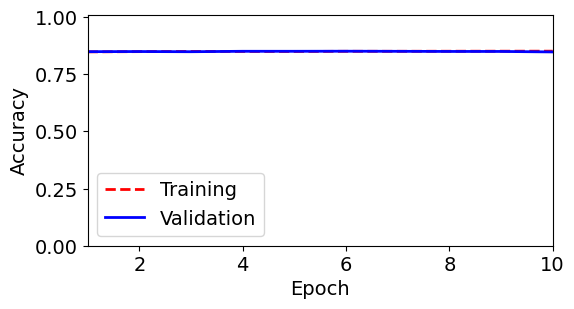


--- Classification Report (Test Set) ---
              precision    recall  f1-score   support

           0       0.86      0.98      0.92     10720
           1       0.00      0.00      0.00       217
           2       0.57      0.16      0.25      1747

    accuracy                           0.85     12684
   macro avg       0.48      0.38      0.39     12684
weighted avg       0.81      0.85      0.81     12684



/Users/hansika/Documents/MLE/env/mle/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/hansika/Documents/MLE/env/mle/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/hansika/Documents/MLE/env/mle/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

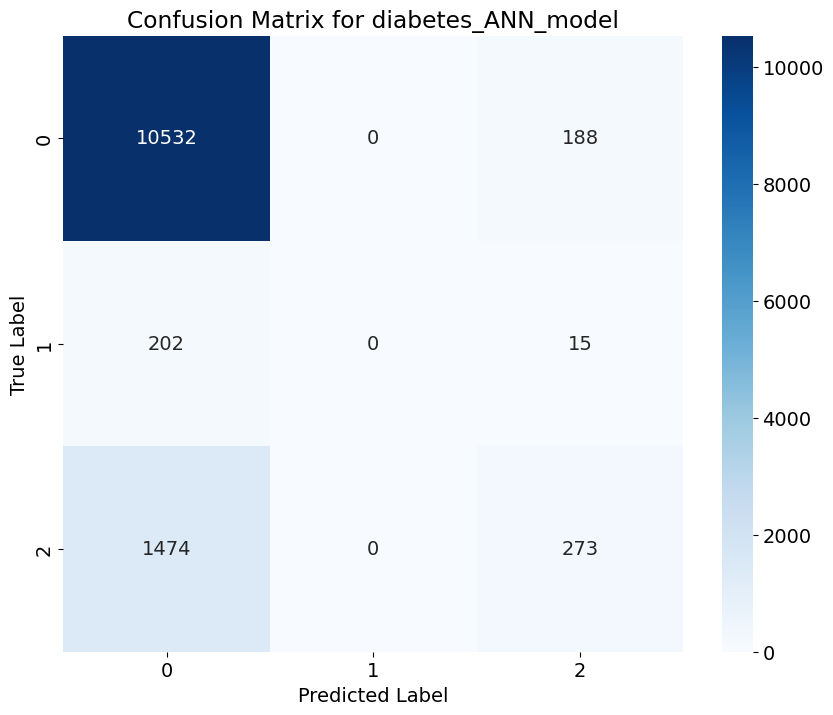

In [14]:
evaluate_model(name, model, eval_data)

In [15]:
name, model = create_compile_model(hidden_widths=[128,64,32]) 
eval_data = train_model(model, verbose=1)

Model: "diabetes_ANN_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_0 (Dense)            (None, 128)               2816      
                                                                 
 hidden_1 (Dense)            (None, 64)                8256      
                                                                 
 hidden_2 (Dense)            (None, 32)                2080      
                                                                 
 output (Dense)              (None, 3)                 99        
                                                                 
Total params: 13251 (51.76 KB)
Trainable params: 13251 (51.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
7135/7135 [==============================] - 3s 400us/step - loss: 0.4005 - accuracy: 0.8468 - val_loss: 0.4019 - val_accuracy: 0.845

[diabetes_ANN_model] Training Accuracy: 85.184%, Validation Accuracy: 85.005%
[diabetes_ANN_model] Test loss: 0.38631, test accuracy: 85.147%


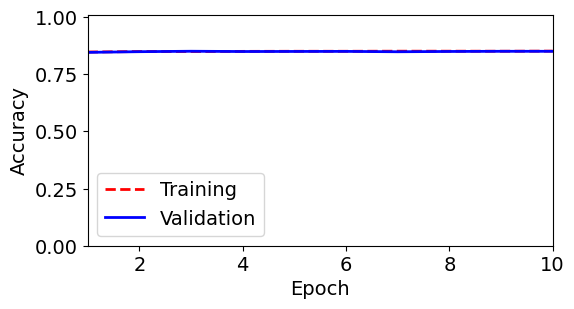


--- Classification Report (Test Set) ---
              precision    recall  f1-score   support

           0       0.86      0.98      0.92     10720
           1       0.00      0.00      0.00       217
           2       0.58      0.15      0.23      1747

    accuracy                           0.85     12684
   macro avg       0.48      0.38      0.38     12684
weighted avg       0.81      0.85      0.81     12684



/Users/hansika/Documents/MLE/env/mle/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/hansika/Documents/MLE/env/mle/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/hansika/Documents/MLE/env/mle/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

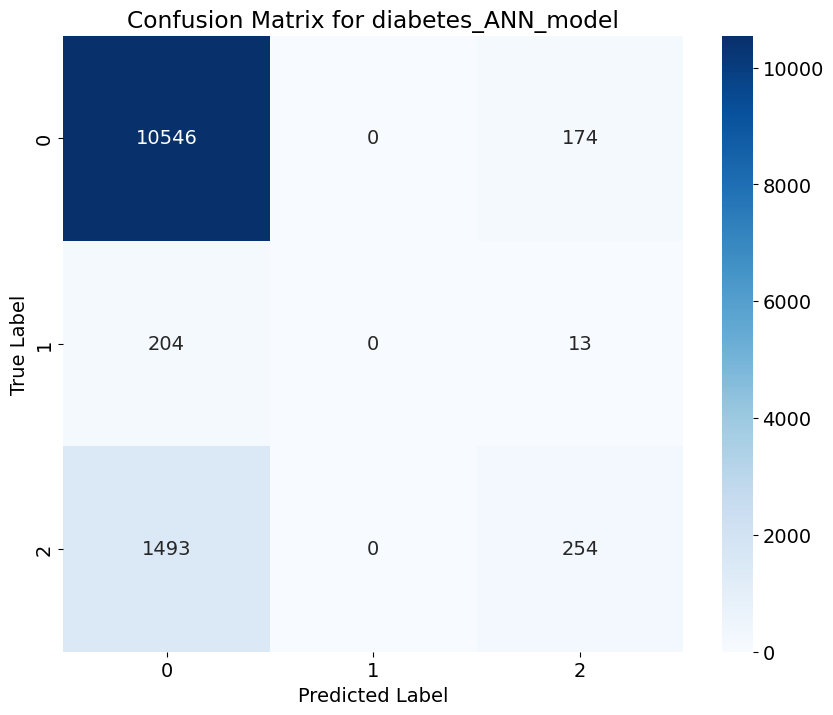

In [16]:
evaluate_model(name, model, eval_data, provide_classification_report=True)

In [13]:
name, model = create_compile_model(hidden_widths=[128,64,32], learning_rate=0.00001) 
eval_data = train_model(model, verbose=1)

Model: "diabetes_ANN_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_0 (Dense)            (None, 128)               2816      
                                                                 
 hidden_1 (Dense)            (None, 64)                8256      
                                                                 
 hidden_2 (Dense)            (None, 32)                2080      
                                                                 
 output (Dense)              (None, 3)                 99        
                                                                 
Total params: 13251 (51.76 KB)
Trainable params: 13251 (51.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


NameError: name 'PerfEvalCustomCallback' is not defined

[diabetes_ANN_model] Training Accuracy: 84.982%, Validation Accuracy: 84.918%
[diabetes_ANN_model] Test loss: 0.38652, test accuracy: 85.344%


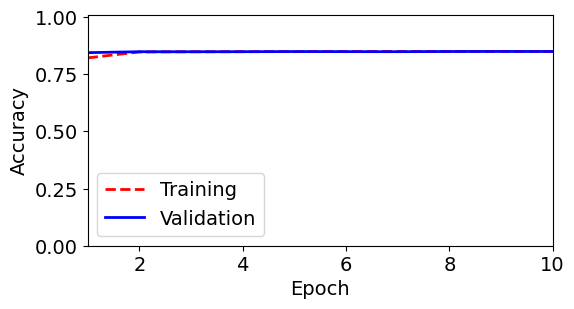


--- Classification Report (Test Set) ---
              precision    recall  f1-score   support

           0       0.86      0.98      0.92     10720
           1       0.00      0.00      0.00       217
           2       0.59      0.17      0.27      1747

    accuracy                           0.85     12684
   macro avg       0.48      0.39      0.40     12684
weighted avg       0.81      0.85      0.81     12684



/Users/hansika/Documents/MLE/env/mle/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/hansika/Documents/MLE/env/mle/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/hansika/Documents/MLE/env/mle/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

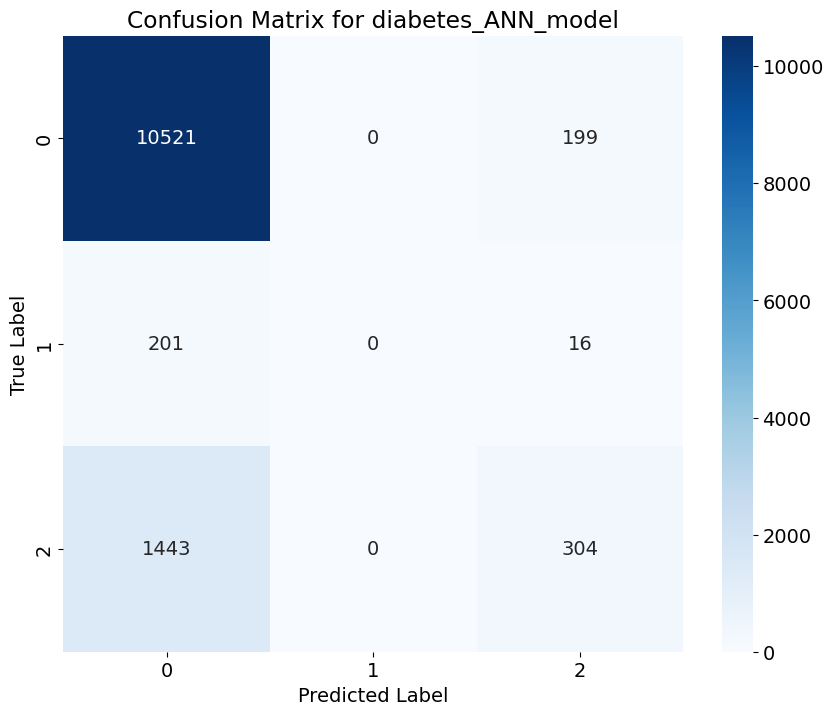

In [26]:
evaluate_model(name, model, eval_data, provide_classification_report=True)

### Now we try to train with providing informationa bout class imbalance

In [7]:
from sklearn.utils.class_weight import compute_class_weight

train_y_labels = np.argmax(train_y, axis=1)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_y_labels),
    y=train_y_labels
)

class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

In [8]:
class_weight_dict

{0: 0.39575251427442254, 1: 18.303030303030305, 2: 2.389300514881326}

In [15]:
name, model = create_compile_model() 
eval_data = train_model(model, verbose=1, class_weights=class_weight_dict)

Model: "diabetes_ANN_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_0 (Dense)            (None, 100)               2200      
                                                                 
 hidden_1 (Dense)            (None, 50)                5050      
                                                                 
 output (Dense)              (None, 3)                 153       
                                                                 
Total params: 7403 (28.92 KB)
Trainable params: 7403 (28.92 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
7135/7135 [==============================] - 3s 362us/step - loss: 0.9699 - accuracy: 0.5979 - val_loss: 0.9581 - val_accuracy: 0.5386
Epoch 2/10
7135/7135 [==============================] - 2s 346us/step - loss: 0.9571 - accuracy: 0.6055 - val_loss: 0.9603 - val_acc

[diabetes_ANN_model] Training Accuracy: 63.232%, Validation Accuracy: 62.930%
[diabetes_ANN_model] Test loss: 0.86040, test accuracy: 62.969%


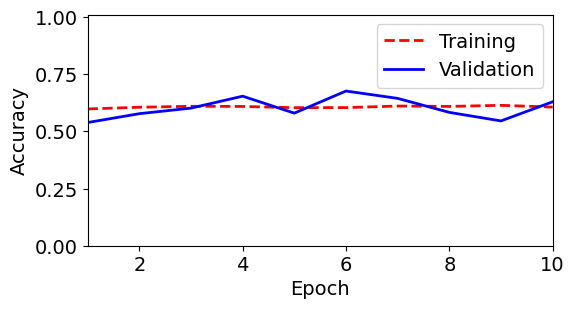


--- Classification Report (Test Set) ---
              precision    recall  f1-score   support

           0       0.96      0.64      0.76     10698
           1       0.03      0.25      0.05       235
           2       0.34      0.64      0.44      1751

    accuracy                           0.63     12684
   macro avg       0.44      0.51      0.42     12684
weighted avg       0.85      0.63      0.71     12684



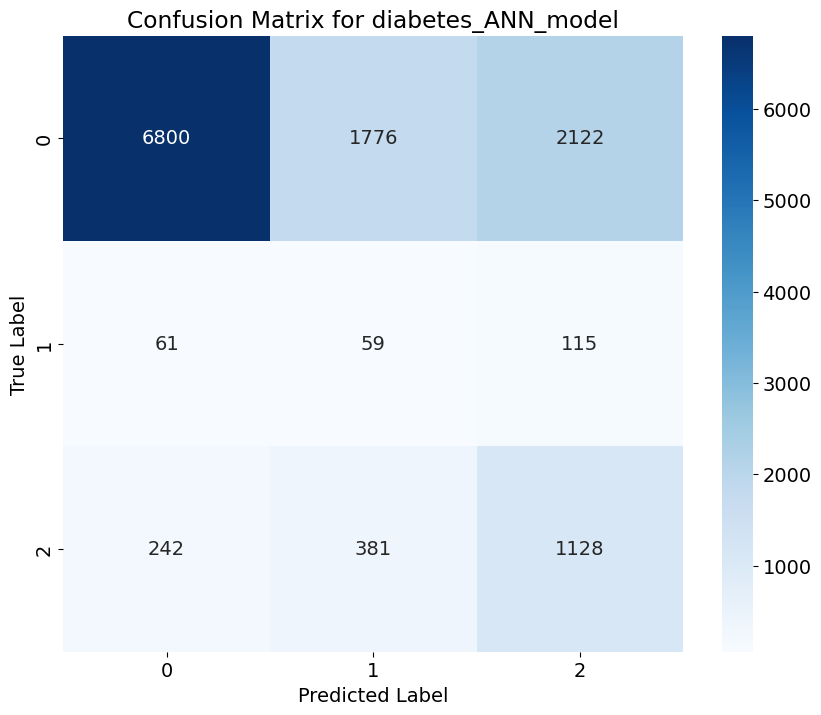

In [16]:
evaluate_model(name, model, eval_data)

## Training with resampled data